# Classification with MNIST dataset


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
import math

In [170]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

## Explore dataset

The shape of x_train.shape is: (60000, 28, 28)
the shape of x_train.shape is: (60000,)
The shape of x_test.shape is: (10000, 28, 28)
the shape of y_test.shape is: (10000,)


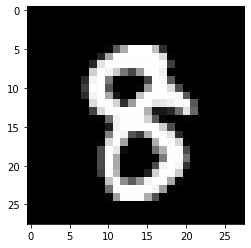

The answer is: 8


In [171]:
img = x_train[9900]
ans = y_train[9900]

print("The shape of x_train.shape is:", x_train.shape)
print("the shape of x_train.shape is:", y_train.shape)

print("The shape of x_test.shape is:", x_test.shape)
print("the shape of y_test.shape is:", y_test.shape)

plt.imshow(img, cmap='gray')
plt.show()
print("The answer is:", ans)

### I want to rearrange each image into a 784 x 1 column vector. Since there are 60000 images, the final output will be a 784 x 60000 matrix

In [172]:
inputs = x_train.reshape((60000, 28*28)).T
print("the new shape is for the training set it: " ,inputs.shape)

the new shape is for the training set it:  (784, 60000)


### The outputs are real numbers. But I want it to be coded into one hot. The final output vectors should be a 10 x 1 vector since there are 60000 training examples it should be a 10 x 60000 vector

In [173]:
# one-hot encoding


def one_hot(Y):
    one_hot_Y = np.zeros((Y.size,10))            # This will make a 60 000 by 10 vector
    
    one_hot_Y[np.arange(Y.size), Y] = 1          #  
    one_hot_Y = one_hot_Y
    return one_hot_Y


one_hot_y = one_hot(y_train)

one_hot_y = one_hot_y.T

one_hot_y[:,9900]

array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0.])

In [174]:
one_hot_y.shape

(10, 60000)

## Initializing Weights and Biases



In [175]:
def initialize_parameters(layers_dims):
    # The input is an array of numbers indicating how many nodes in the layers
    
    parameters = {}
    
    for l in range(1,len(layers_dims)):
        parameters["W" + str(l)] = np.random.normal(0, 1/math.sqrt(layers_dims[l]), (layers_dims[l],layers_dims[l-1] ))
        
        
        parameters["b" + str(l)] = np.zeros((layers_dims[l],1))
    
    # This pulls numbers with a normal distribution with a variance of 100^2 and a mean of 0
    # Saves the parameters
    
    return parameters

### Try example of weights and biases

In this example: 

there are 2 hidden layers and an output layer


layer 1: 32 neurons
layer 2: 32 neurons
output : 10 neurons




The shape of  W1 is:  (32, 784)
The shape of  b1 is:  (32, 1)
The shape of  W2 is:  (32, 32)
The shape of  b2 is:  (32, 1)
The shape of  W3 is:  (10, 32)
The shape of  b3 is:  (10, 1)


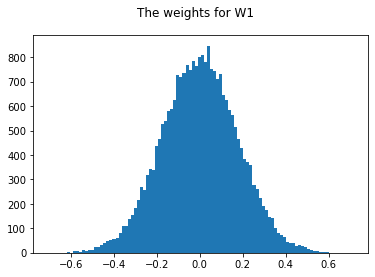

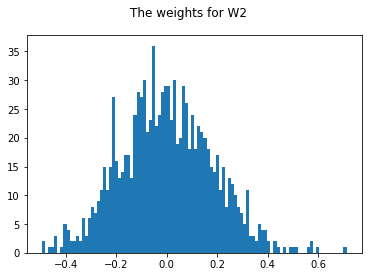

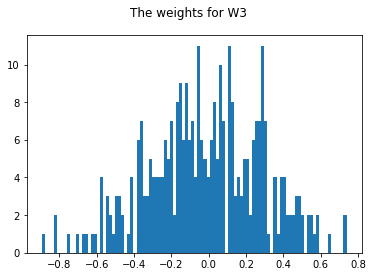

In [249]:
layer_dims = [784,32,32,10]
parameters = initialize_parameters(layer_dims)

# Check if they are right:

for item in list(parameters.keys()):
    if "W" in item:
        plt.figure()
        plt.suptitle("The weights for " + item)
        plt.hist(parameters[item].flatten(), bins=100)
    print("The shape of ", item, "is: ", parameters[item].shape )

# Activation functions

In [250]:
def Sigmoid(Z):
    Z = np.clip(Z, -500, 500)
    output = 1/(1+np.exp(-Z))
    return output

def Softmax(Z):
    m = Z.shape[1]
    y = np.exp(Z)
    
    return (y / y.sum())

# Forward Propagation

In [251]:
def forward_prop(X,parameters):
    """
    Forward propagation for a neural network architecture like:
    INPUT -> SIGMOID -> SIGMOID ... -> SOFTMAX
    parameters is a dictionary with W's and b's
    X is the input
    """
    caches = []
    A = X
    L = len(parameters) // 2
    
    for l in range(1,L):
        A_prev = A
        
        W = parameters["W"+str(l)]
        b = parameters["b"+str(l)]
        
        Z = np.dot(W,A_prev) + b
        A = Sigmoid(Z)
        
        
        caches.append((A_prev,W,b,Z))                # The caches is a list of tuples, each tuple has the input to the neural net and the weights and biases and the output of that layer
        
    A_prev = A
    W = parameters['W' + str(L)]
    b = parameters['b' + str(L)]
    
    Z = np.dot(W,A_prev) + b
    AL = Softmax(Z)
    
    
    caches.append((A_prev,W,b,Z))
    
    return AL, caches

## Let's try with just one example to see if it works:

In [202]:
X = inputs[:,9].reshape((784, 1))

output, caches = forward_prop(X,parameters)

In [253]:
print(output)
print(len(caches))

[[0.29984781]
 [0.04616767]
 [0.08329157]
 [0.01732785]
 [0.12968786]
 [0.02442668]
 [0.15752178]
 [0.16047187]
 [0.01589902]
 [0.06535788]]
3


# Cost Function:

In [222]:
def cross_entropy_loss(y, yHat):
    m = y.shape[1]
    return -np.sum(np.multiply(y , np.log(yHat)))/m   # exapling why we use this function

## Let's find the error for the example we did before

In [223]:
cross_entropy_loss(one_hot_y[:,9].reshape(10,1),output)

2.7278772075354762

### error is high

# Backpropagation: Derivatives

In [224]:
def dsigmoid(x): # Derivative of sigmoid
    return Sigmoid(x) * (1 - Sigmoid(x))


# Backpropagation

In [261]:
def back_prop(AL, Y, caches):
    """
    Backward propagation for a neural network architecture like:
    INPUT -> SIGMOID -> SIGMOID ... -> SOFTMAX
    caches is a list of tuples (A_prev, W, b, Z)
    AL is the output of the last layer (SOFTMAX)
    Y is the true labels
    """
    
    grads = {}
    L = len(caches)
    m = AL.shape[1]
     
    A_prev, W, b, Z = caches[L-1]
    
    
    # Last layer gradients
    dWL = np.dot((AL - Y), A_prev.T) /m       # this is the derivative of softmax and the cross entropy loss function (explain later)
    dbL = np.sum((AL - Y), axis=1, keepdims=True)/m
    dA_prev = np.dot(W.T,(AL - Y))
    
    grads["dW" + str(L)] = dWL
    grads["db" + str(L)] = dbL
    grads["dA" + str(L-1)]= dA_prev
    
    for l in reversed(range(L-1)):
        A_prev, W, b, Z = caches[l]
        dZ = dA_prev * dsigmoid(Z)
        dW = np.dot(dZ, A_prev.T)/m
        db = np.sum(dZ, axis=1, keepdims=True)/m
        dA_prev = np.dot(W.T, dZ)
        
        grads["dW" + str(l+1)] = dW
        grads["db" + str(l+1)] = db
        grads["dA" + str(l)] = dA_prev
    
    return grads


In [262]:
Y = one_hot_y[:,9].reshape((10, 1))
print("The shape of Y is: ", Y.shape)
print("The shape of the AL is: ", output.shape)

The shape of Y is:  (10, 1)
The shape of the AL is:  (10, 1)


In [263]:
grads = back_prop(output, Y, caches)

for item in grads:
    print("The shape of ", item, "is: " , grads[item].shape)

The shape of  dW3 is:  (10, 32)
The shape of  db3 is:  (10, 1)
The shape of  dA2 is:  (32, 1)
The shape of  dW2 is:  (32, 32)
The shape of  db2 is:  (32, 1)
The shape of  dA1 is:  (32, 1)
The shape of  dW1 is:  (32, 784)
The shape of  db1 is:  (32, 1)
The shape of  dA0 is:  (784, 1)


# Update the parameters

In [264]:
def update_parameters(params, grads, learning_rate):
    
    parameters = params.copy()
    L = len(parameters) // 2
    
    for l in range(L):
        parameters["W" + str(l+1)] = params["W"+str(l+1)] - learning_rate*grads["dW"+str(l+1)]
        parameters["b" + str(l+1)] = params["b"+str(l+1)] - learning_rate*grads["db"+str(l+1)]
        
    return parameters

In [265]:
new_params = update_parameters(parameters, grads, 0.001)

In [266]:
for thing in new_params:
    print("The shape of ", thing, "is: " , new_params[thing].shape)

The shape of  W1 is:  (32, 784)
The shape of  b1 is:  (32, 1)
The shape of  W2 is:  (32, 32)
The shape of  b2 is:  (32, 1)
The shape of  W3 is:  (10, 32)
The shape of  b3 is:  (10, 1)


# Now we are going to to Forward Prop on the new parameters and compute the new cost

In [267]:
X = inputs[:,9].reshape((784, 1))

new_output, caches = forward_prop(X,new_params)

In [268]:
new_output

array([[0.03514269],
       [0.07152485],
       [0.09552097],
       [0.09337493],
       [0.04685222],
       [0.08047147],
       [0.13075844],
       [0.15775461],
       [0.02087986],
       [0.26771996]])

In [269]:
cross_entropy_loss(one_hot_y[:,9].reshape(10,1),new_output)

1.3178137687414666

# Test dataset

In [270]:
def Test_dataset(X,Y,parameters):
    
    test_output, caches = forward_prop(X,parameters)
    #correct_guesses = np.sum(Y * test_output)
    #correct_guess_percent = format((correct_guesses / Y.shape[1]) * 100, ".2f")
    print(cross_entropy_loss(Y, test_output))
    #print("Accuracy (# of correct guesses):", correct_guesses, "/", Y.shape[1], "(", correct_guess_percent, "%)")
    
    
    y_pred_class = np.argmax(test_output, axis=0)
    y_true_class = np.argmax(Y, axis=0)
    correctly_classified = np.sum(y_pred_class == y_true_class)
    accuracy = correctly_classified / y_true_class.size
    accuracy_percentage = accuracy * 100
    print(accuracy_percentage)
    return test_output


In [271]:
inputs = x_test.reshape((10000, 28*28)).T
one_hot_y = one_hot(y_test).T

h = Test_dataset(inputs,one_hot_y,parameters)

11.702298528055126
10.100000000000001


# Function for the whole thing:



In [281]:
def Model(X,Y):
    layer_dims = [784,32,32,67,10]
    parameters = initialize_parameters(layer_dims)
    
    for n in range(3):
        print()
        print("Epoch", n +1)
        print()
        for i in range(100):
            output, caches = forward_prop(X,parameters)
            if i%10 ==0:
                print("The cost after :", i, "repitions is: ", cross_entropy_loss(Y,output))
            grads = back_prop(output, Y, caches)
            parameters = update_parameters(parameters, grads, 0.001)
    return parameters

In [282]:
X = inputs
Y = one_hot_y

params = Model(X,Y)


Epoch 1

The cost after : 0 repitions is:  12.149424605604684
The cost after : 10 repitions is:  12.14988581159892
The cost after : 20 repitions is:  12.150355799862789
The cost after : 30 repitions is:  12.150834506341184
The cost after : 40 repitions is:  12.15132188500427
The cost after : 50 repitions is:  12.151817940421829
The cost after : 60 repitions is:  12.152322713775451
The cost after : 70 repitions is:  12.152836233719762
The cost after : 80 repitions is:  12.153358488224475
The cost after : 90 repitions is:  12.153889435093493

Epoch 2

The cost after : 0 repitions is:  12.154429022557727
The cost after : 10 repitions is:  12.154977199280973
The cost after : 20 repitions is:  12.1555339140913
The cost after : 30 repitions is:  12.156099114058943
The cost after : 40 repitions is:  12.156672748555897
The cost after : 50 repitions is:  12.157254780204159
The cost after : 60 repitions is:  12.157845196358428
The cost after : 70 repitions is:  12.158444016828566
The cost after

In [274]:
def Test_dataset(X,Y,parameters):
    
    test_output, caches = forward_prop(X,parameters)
    #correct_guesses = np.sum(Y * test_output)
    #correct_guess_percent = format((correct_guesses / Y.shape[1]) * 100, ".2f")
    print(cross_entropy_loss(Y, test_output))
    #print("Accuracy (# of correct guesses):", correct_guesses, "/", Y.shape[1], "(", correct_guess_percent, "%)")
    
    
    y_pred_class = np.argmax(test_output, axis=0)
    y_true_class = np.argmax(Y, axis=0)
    correctly_classified = np.sum(y_pred_class == y_true_class)
    accuracy = correctly_classified / y_true_class.size
    accuracy_percentage = accuracy * 100
    print(accuracy_percentage)
    return test_output



In [275]:
inputs = x_test.reshape((10000, 28*28)).T
one_hot_y = one_hot(y_test).T

h = Test_dataset(inputs,one_hot_y,params)

11.853825785064904
11.28


In [ ]:
for thing in params:
    print("The shape of ", thing, "is: " , params[thing].shape)

In [ ]:
one_hot_y.T.shape

In [ ]:
one_hot_y[:,9]

In [ ]:
h[:,9]

In [ ]:
h[:,9]*one_hot_y[:,9]

In [84]:
len(parameters)

6

In [248]:
len([1,2,3,4])

4

In [280]:
print(len(params))

6
